In [6]:
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt

# TF-IDF Weight calculation for symptom representation

---
- Input : symptom_disease_dict_{RUN_TAG}.json - Contains HADM_ID to Symptom text and Diagnosis mapping as json object
- Input : icd9_dict_{RUN_TAG}.json - Contains ICD9 Codes of TOP N Diagnoses
- Output : weight_i_j_norm{tag}.csv - TF-IDF weights for symptom representation

In [7]:
cwd = os.getcwd()
print(f"Current working directory : {cwd}")
# Let's define some constants that will be used below in our processing
MAX_NUMBER_OF_DISEASE = 100
# RUN_TAG = "_v2.0" - for 50 symptoms
RUN_TAG = f"_{MAX_NUMBER_OF_DISEASE}_v2.0"
data_dir = cwd + "/../../data/"
SYMPTOM_DISEASE_DICT_FILE_PATH = data_dir + f"symptom_disease_dict_{RUN_TAG}.json"
ICD9_FILE_PATH = data_dir + f"icd9_dict_{RUN_TAG}.json"
SYMPTOM_DICT_FILE_PATH = data_dir + f"symptoms_dict_{RUN_TAG}.json"
TF_IDF_WEIGHTS_FILE_PATH = data_dir + f"weight_i_j_{RUN_TAG}.csv"
TF_IDF_NORM_WEIGHTS_FILE_PATH = data_dir + f"weight_i_j_norm_{RUN_TAG}.csv"

Current working directory : /Users/vijaymi/Studies/CS-598-DL4Health/Project/135-Disease-Inference-Method/disease_pred_using_bilstm/source


**Load dictionary with symptoms and diagnoses created by data preparation step.**

In [8]:
icd9_dict = None
with open(ICD9_FILE_PATH, 'r') as f:
            icd9_dict = json.load(f)
        
symptom_disease_dict = None
with open(SYMPTOM_DISEASE_DICT_FILE_PATH, 'r') as f:
            symptom_disease_dict = json.load(f)

symptoms_dict = None
with open(SYMPTOM_DICT_FILE_PATH, 'r') as f:
    symptoms_dict = json.load(f)

### Create Symptoms <-> Diagnoses Matrix

Note: This computation is little slow and may take few minutes to run.

In [9]:
number_of_diseases = len(icd9_dict)
number_of_symptoms = len(symptoms_dict)
diagnoses_symptom_vector = pd.DataFrame(np.zeros((number_of_symptoms, number_of_diseases)))

for hadm_id in symptom_disease_dict.keys():
    # print(f"processing {index} - {record}")
    symp_list, icd9_list = symptom_disease_dict[hadm_id]
    for symptom_value in symp_list:
        if symptom_value not in symptoms_dict:
            continue
        for diagnosis_value in icd9_list:
            if diagnosis_value not in icd9_dict:
                continue
            
            # set the vector
            diagnoses_symptom_vector.iat[symptoms_dict[symptom_value], icd9_dict[diagnosis_value]] += 1
            
diagnoses_symptom_vector.T.head()

,0,1,2,3,4,5,6,7,8,9,...,4016,4017,4018,4019,4020,4021,4022,4023,4024,4025
0,327.0,6313.0,19660.0,195.0,630.0,6937.0,331.0,14067.0,207.0,157.0,...,1.0,4.0,1.0,5.0,6.0,5.0,3.0,8.0,1.0,8.0
1,96.0,4857.0,12702.0,96.0,2248.0,5556.0,564.0,10862.0,224.0,154.0,...,3.0,0.0,5.0,3.0,1.0,4.0,2.0,4.0,2.0,4.0
2,542.0,5903.0,10112.0,279.0,1986.0,6338.0,750.0,9406.0,327.0,192.0,...,6.0,4.0,3.0,3.0,6.0,5.0,5.0,7.0,3.0,0.0
3,162.0,3336.0,11478.0,168.0,1948.0,4223.0,551.0,9624.0,333.0,142.0,...,1.0,1.0,4.0,2.0,2.0,2.0,1.0,2.0,0.0,4.0
4,269.0,4114.0,11958.0,165.0,1539.0,4760.0,516.0,10171.0,293.0,121.0,...,0.0,1.0,1.0,3.0,1.0,3.0,3.0,7.0,1.0,5.0


In [10]:
diagnoses_symptom_vector.shape
diagnoses_symptom_vector_binary = (diagnoses_symptom_vector > 0).astype(float)
diagnoses_symptom_vector_binary.head()
diagnoses_symptom_count = diagnoses_symptom_vector_binary.sum(axis=1)

print(f"diagnoses_symptom_count : {diagnoses_symptom_count.shape}")
log_N_di = np.log(MAX_NUMBER_OF_DISEASE / diagnoses_symptom_count)

weight_i_j = diagnoses_symptom_vector.T * log_N_di
print(f"diagnoses_symptom_count[2] : {diagnoses_symptom_count[2]}")
print(f"weight_i_j.shape : {weight_i_j.shape}")
print(f"log_N_di[2] : {log_N_di[2]}")
weight_i_j.head(20)

diagnoses_symptom_count : (4026,)
diagnoses_symptom_count[2] : 100.0
weight_i_j.shape : (100, 4026)
log_N_di[2] : 0.0


,0,1,2,3,4,5,6,7,8,9,...,4016,4017,4018,4019,4020,4021,4022,4023,4024,4025
0,3.286460,0.0,0.0,1.959815,12.727706,0.0,0.0,0.0,0.0,13.090913,...,0.673345,5.388295,0.634878,3.366723,3.478911,3.080931,2.265068,3.954371,0.755023,8.173210
1,0.964832,0.0,0.0,0.964832,45.415686,0.0,0.0,0.0,0.0,12.840768,...,2.020034,0.000000,3.174391,2.020034,0.579818,2.464745,1.510045,1.977185,1.510045,4.086605
2,5.447282,0.0,0.0,2.804044,40.122577,0.0,0.0,0.0,0.0,16.009269,...,4.040067,5.388295,1.904635,2.020034,3.478911,3.080931,3.775113,3.460074,2.265068,0.000000
3,1.628154,0.0,0.0,1.688456,39.354874,0.0,0.0,0.0,0.0,11.840188,...,0.673345,1.347074,2.539513,1.346689,1.159637,1.232372,0.755023,0.988593,0.000000,4.086605
4,2.703540,0.0,0.0,1.658305,31.091967,0.0,0.0,0.0,0.0,10.089175,...,0.000000,1.347074,0.634878,2.020034,0.579818,1.848558,2.265068,3.460074,0.755023,5.108256
5,9.990034,0.0,0.0,5.628188,47.132916,0.0,0.0,0.0,0.0,14.341637,...,1.346689,8.082442,0.634878,0.673345,4.058729,1.232372,3.020090,1.977185,0.755023,2.043302
6,1.809060,0.0,0.0,2.150772,54.809945,0.0,0.0,0.0,0.0,12.257097,...,2.693378,0.000000,5.079026,0.673345,1.739455,3.080931,2.265068,1.977185,1.510045,1.021651
7,1.407047,0.0,0.0,1.366846,27.819128,0.0,0.0,0.0,0.0,9.672267,...,4.713412,4.041221,2.539513,2.020034,5.218366,4.313303,3.020090,2.471482,3.020090,1.021651
8,3.165856,0.0,0.0,2.301527,36.082035,0.0,0.0,0.0,0.0,12.924149,...,4.713412,0.000000,1.904635,2.020034,1.159637,0.616186,4.530136,1.977185,3.775113,1.021651
9,4.221141,0.0,0.0,2.190973,50.163322,0.0,0.0,0.0,0.0,10.255938,...,5.386756,0.000000,2.539513,1.346689,5.218366,3.697117,0.000000,1.977185,2.265068,0.000000


In [11]:
from sklearn import preprocessing
weight_i_j = weight_i_j.fillna(0)
weight_i_j = weight_i_j.replace(np.inf, 0)
weight_i_j = weight_i_j.replace(-np.inf, 0)
weight_i_j.head(20)

x = weight_i_j.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
weight_i_j_norm = pd.DataFrame(x_scaled)
weight_i_j_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,4016,4017,4018,4019,4020,4021,4022,4023,4024,4025
0,0.328974,0.0,0.0,0.348214,0.200701,0.0,0.0,0.0,0.0,0.817708,...,0.090909,0.666667,0.125,0.833333,0.666667,0.714286,0.500000,1.000,0.2,1.000
1,0.096579,0.0,0.0,0.171429,0.716152,0.0,0.0,0.0,0.0,0.802083,...,0.272727,0.000000,0.625,0.500000,0.111111,0.571429,0.333333,0.500,0.4,0.500
2,0.545272,0.0,0.0,0.498214,0.632686,0.0,0.0,0.0,0.0,1.000000,...,0.545455,0.666667,0.375,0.500000,0.666667,0.714286,0.833333,0.875,0.6,0.000
3,0.162978,0.0,0.0,0.300000,0.620580,0.0,0.0,0.0,0.0,0.739583,...,0.090909,0.166667,0.500,0.333333,0.222222,0.285714,0.166667,0.250,0.0,0.500
4,0.270624,0.0,0.0,0.294643,0.490284,0.0,0.0,0.0,0.0,0.630208,...,0.000000,0.166667,0.125,0.500000,0.111111,0.428571,0.500000,0.875,0.2,0.625


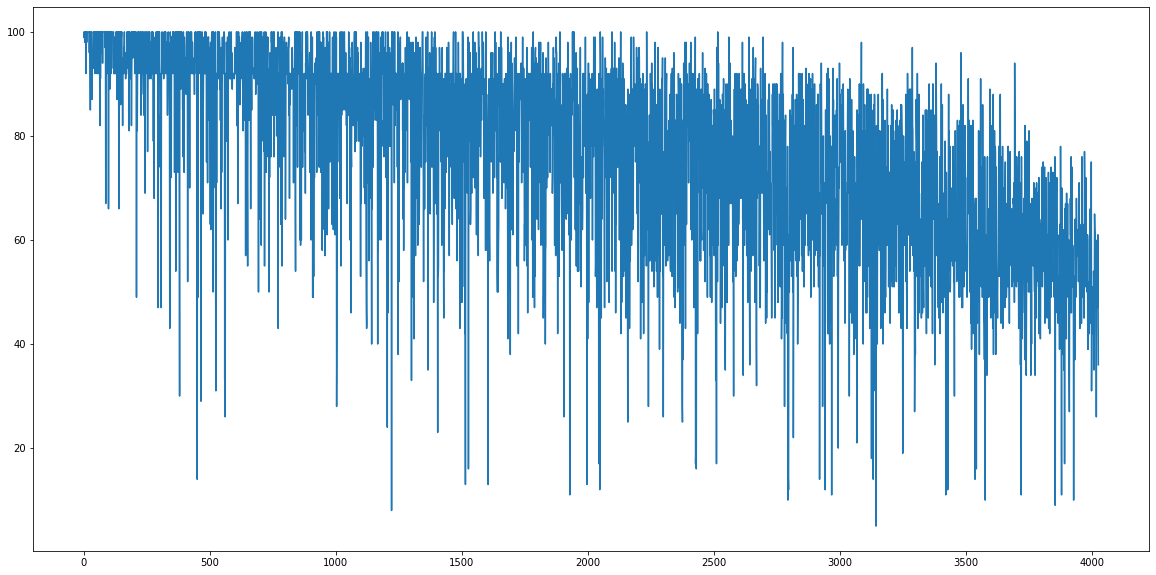

In [12]:
plt.figure(figsize=(20,10))
plt.plot(diagnoses_symptom_count.index, diagnoses_symptom_count)

<h4> Plot of Top 50 disease by associated symptom count </h4>

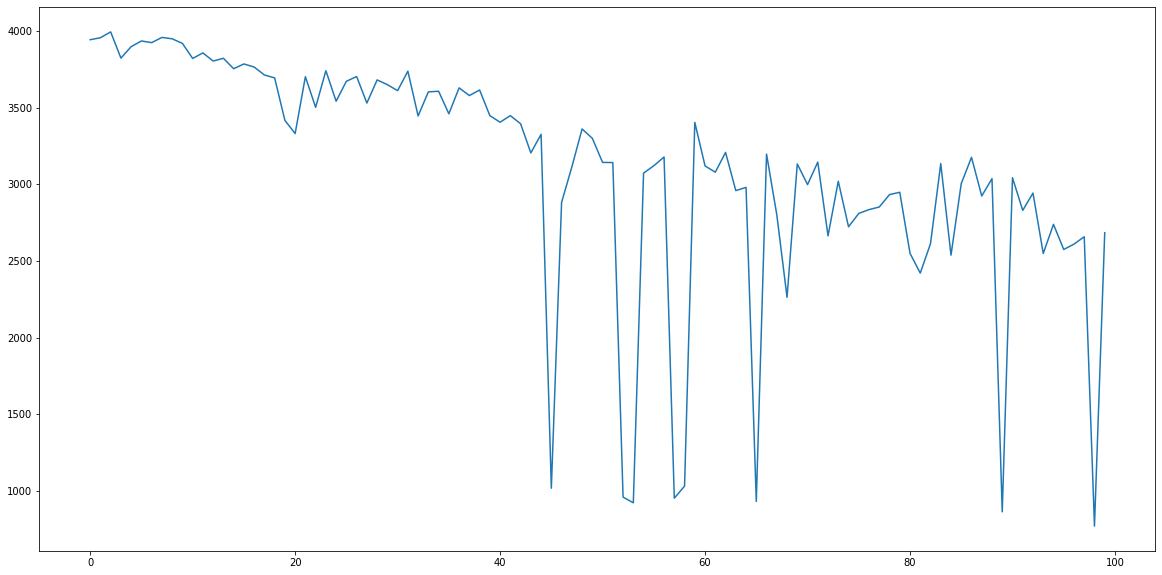

In [13]:
diag_by_symptom_count = diagnoses_symptom_vector_binary.sum(axis=0)
plt.figure(figsize=(20,10))
plt.plot(diag_by_symptom_count.index, diag_by_symptom_count)

<h4> Analysis of Diagnosis count by Hospital Admissions</h4>

In [14]:
top_N_filtered['ICD9_3CHAR'].value_counts()
top_N_diag_count_by_admission = top_N_filtered.groupby(['HADM_ID'], as_index=False)['ICD9_3CHAR'].count()
plt.figure(figsize=(30,20))
plt.hist(top_N_diag_count_by_admission['ICD9_3CHAR'][:-1], bins=50)

NameError: name 'top_N_filtered' is not defined

<h3>Saving all the results to files  </h3>

In [15]:
weight_i_j.to_csv(TF_IDF_WEIGHTS_FILE_PATH, index=False)
weight_i_j_norm.to_csv(TF_IDF_NORM_WEIGHTS_FILE_PATH, index=False)